# Analysis on inflation effects on US

In [1]:
!pip install fredapi


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing the necessary modules to perform exploratory data analysis and visualize results

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
plt.rcParams['font.size'] = 8


from fredapi import Fred
fred_key = '41025c4035a46a9fa96e34da3ee63bf4'

## To use the FRED api, I need to create Fred Object to search and access data

In [3]:
fred = Fred(api_key = fred_key)

## Search for Economic Data

In [4]:
fred.search('S&P', order_by = 'popularity')

id realtime_start realtime_end  \
series id                                                        
BAMLH0A0HYM2          BAMLH0A0HYM2     2022-11-12   2022-11-12   
CSUSHPINSA              CSUSHPINSA     2022-11-12   2022-11-12   
BAMLH0A0HYM2EY      BAMLH0A0HYM2EY     2022-11-12   2022-11-12   
SP500                        SP500     2022-11-12   2022-11-12   
CSUSHPISA                CSUSHPISA     2022-11-12   2022-11-12   
...                            ...            ...          ...   
DDDM07VEA156NWDB  DDDM07VEA156NWDB     2022-11-12   2022-11-12   
POPTTLGBA148NRUG  POPTTLGBA148NRUG     2022-11-12   2022-11-12   
DDOI02GTA156NWDB  DDOI02GTA156NWDB     2022-11-12   2022-11-12   
DDDI01KWA156NWDB  DDDI01KWA156NWDB     2022-11-12   2022-11-12   
QJPPAM770A              QJPPAM770A     2022-11-12   2022-11-12   

                                                              title  \
series id                                                             
BAMLH0A0HYM2      ICE BofA US High Yield Index Option-Adjusted S...   
CSUSHPINSA          S&P/Case-Shiller U.S. National Home Price Index   
BAMLH0A0HYM2EY         ICE BofA US High Yield Index Effective Yield   
SP500                                                       S&P 500   
CSUSHPISA           S&P/Case-Shiller U.S. National Home Price Index   
...                                                             ...   
DDDM07VEA156NWDB  Outstanding Total International Debt Securitie...   
POPTTLGBA148NRUG                      Population for United Kingdom   
DDOI02GTA156NWDB                 Bank Deposits to GDP for Guatemala   
DDDI01KWA156NWDB  Private Credit by Deposit Money Banks to GDP f...   
QJPPAM770A        Total Credit to Private Non-Financial Sector, ...   

                 observation_start observation_end                  frequency  \
series id                                                                       
BAMLH0A0HYM2            1996-12-31      2022-11-09               Daily, Close   
CSUSHPINSA              1987-01-01      2022-08-01                    Monthly   
BAMLH0A0HYM2EY          1996-12-31      2022-11-09               Daily, Close   
SP500                   2012-11-12      2022-11-11               Daily, Close   
CSUSHPISA               1987-01-01      2022-08-01                    Monthly   
...                            ...             ...                        ...   
DDDM07VEA156NWDB        1980-01-01      2019-01-01                     Annual   
POPTTLGBA148NRUG        1950-01-01      2019-01-01                     Annual   
DDOI02GTA156NWDB        1960-01-01      2020-01-01                     Annual   
DDDI01KWA156NWDB        1962-01-01      2018-01-01                     Annual   
QJPPAM770A              1964-10-01      2022-01-01  Quarterly, End of Quarter   

                 frequency_short                units         units_short  \
series id                                                                   
BAMLH0A0HYM2                   D              Percent                   %   
CSUSHPINSA                     M   Index Jan 2000=100  Index Jan 2000=100   
BAMLH0A0HYM2EY                 D              Percent                   %   
SP500                          D                Index               Index   
CSUSHPISA                      M   Index Jan 2000=100  Index Jan 2000=100   
...                          ...                  ...                 ...   
DDDM07VEA156NWDB               A              Percent                   %   
POPTTLGBA148NRUG               A  Millions of Persons     Mil. of Persons   
DDOI02GTA156NWDB               A              Percent                   %   
DDDI01KWA156NWDB               A              Percent                   %   
QJPPAM770A                     Q    Percentage of GDP   Percentage of GDP   

                      seasonal_adjustment seasonal_adjustment_short  \
series id                                                             
BAMLH0A0HYM2      Not Seasonally Adjusted          

## Pulling Raw Data & Plotting for S&P

In [5]:
sp500 = fred.get_series(series_id = 'SP500')

<AxesSubplot: title={'center': 'S&P 500'}>

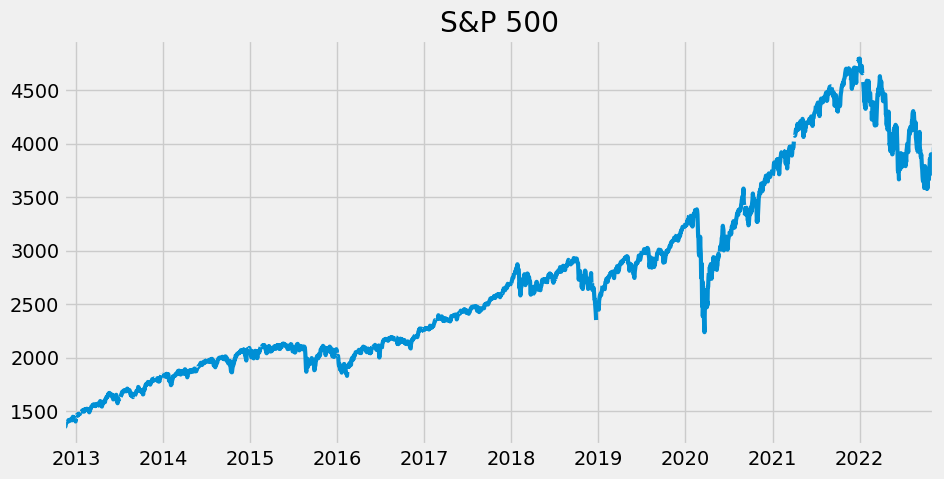

In [6]:
sp500.plot(figsize = (10, 5), title = 'S&P 500', lw = 3)

## Pulling and Joining multiple data series

<AxesSubplot: >

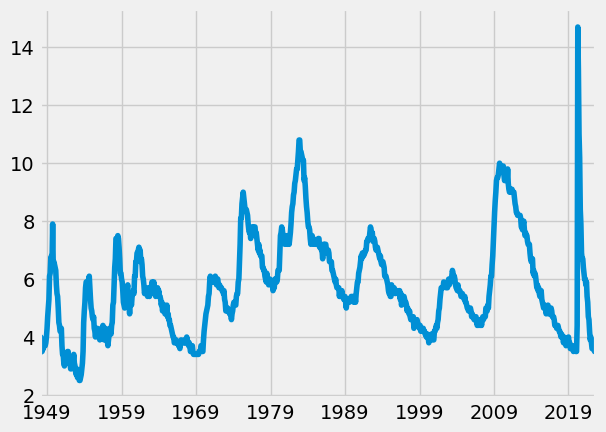

In [7]:
fred.search('unemployment')
unrate = fred.get_series(series_id = 'UNRATE')
unrate.plot()

In [8]:
unemp_df = fred.search('unemployment rate state', filter = ('frequency', 'Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [9]:
total_results = []
for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    total_results.append(results)
    time.sleep(0.1)
unemp_results = pd.concat(total_results, axis = 1)

In [10]:
cols_to_drop = []

for i in unemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
unemp_results = unemp_results.drop(columns = cols_to_drop, axis = 1)

In [61]:
unemp_states = unemp_results.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in', '').to_dict()
unemp_states.columns = [id_to_state[c] for c in unemp_states.columns]
unemp_states.columns = [c.strip() for c in unemp_states.columns]

In [12]:
px.line(unemp_states)

## Pull Unemployment Rate data for each state during May 2020

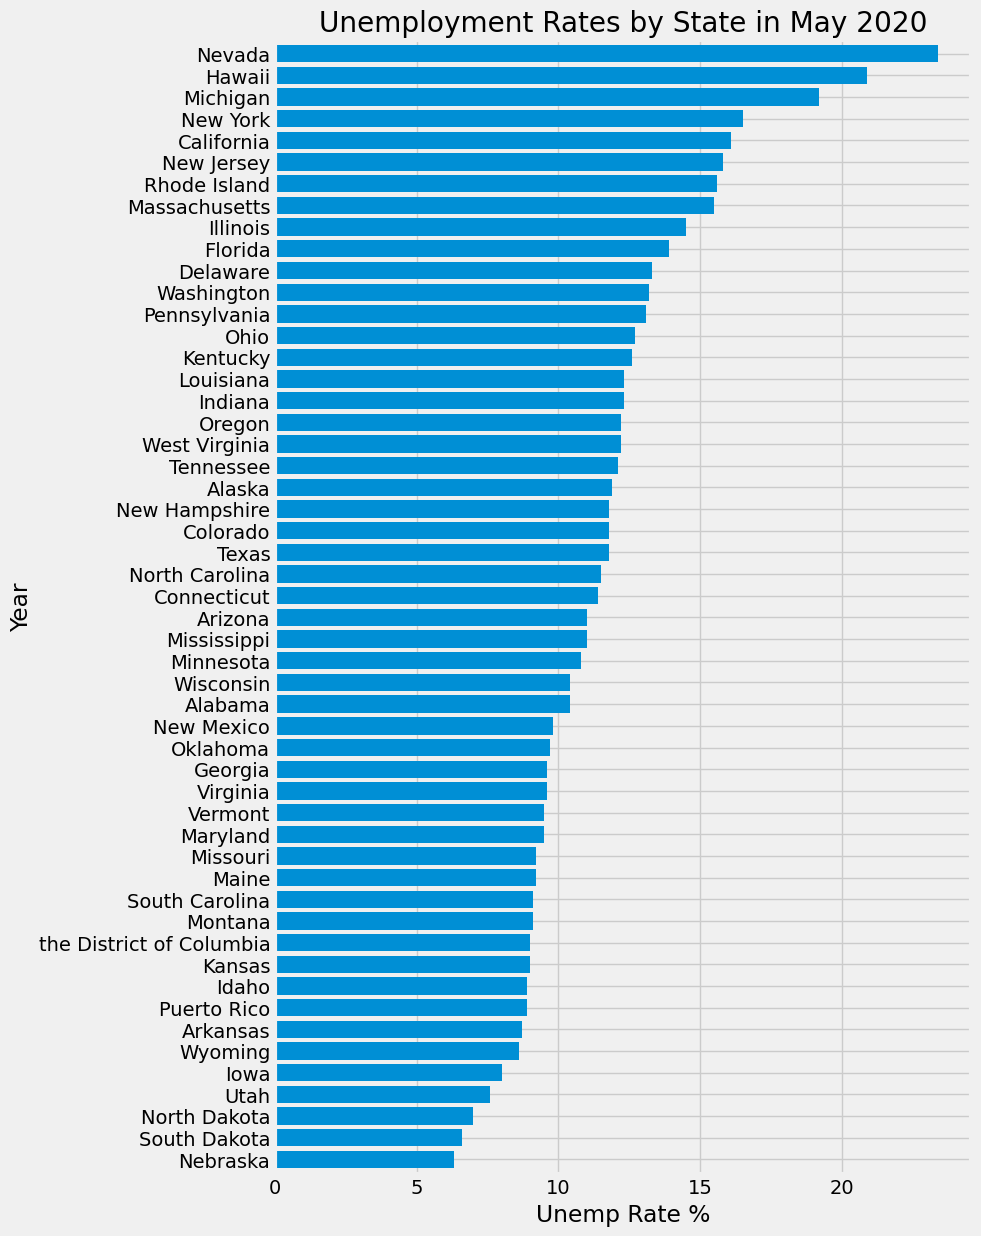

In [13]:
fig = unemp_states.loc[unemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind = "barh", figsize = (8, 14), width = 0.8, title = "Unemployment Rates by State in May 2020", xlabel = "Unemp Rate %", ylabel = "Year")
fig.legend().remove()
plt.show()

In [14]:
part_df = fred.search("participation rate state", filter = ('frequency', 'Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"' )
part_id_to_state = part_df['title'].str.replace("Labor Force Participation Rate for", '').to_dict()

In [15]:
total_results = []
for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    total_results.append(results)
    time.sleep(0.1)
part_state = pd.concat(total_results, axis = 1)
part_state.columns = [part_id_to_state[c] for c in part_state.columns]

In [16]:
cols_to_drop = []

for i in part_state.columns:
    if len(i) > 15:
        cols_to_drop.append(i)
        
part_state = part_state.drop(columns = cols_to_drop, axis = 1)
part_state = part_state.dropna()

In [17]:
part_state.columns = [c.strip() for c in part_state.columns]
unemp_states = unemp_states.rename(columns = {"the District of Columbia": "District of Columbia"})

## Plotting Unemployment vs Participation between 2020 and 2021

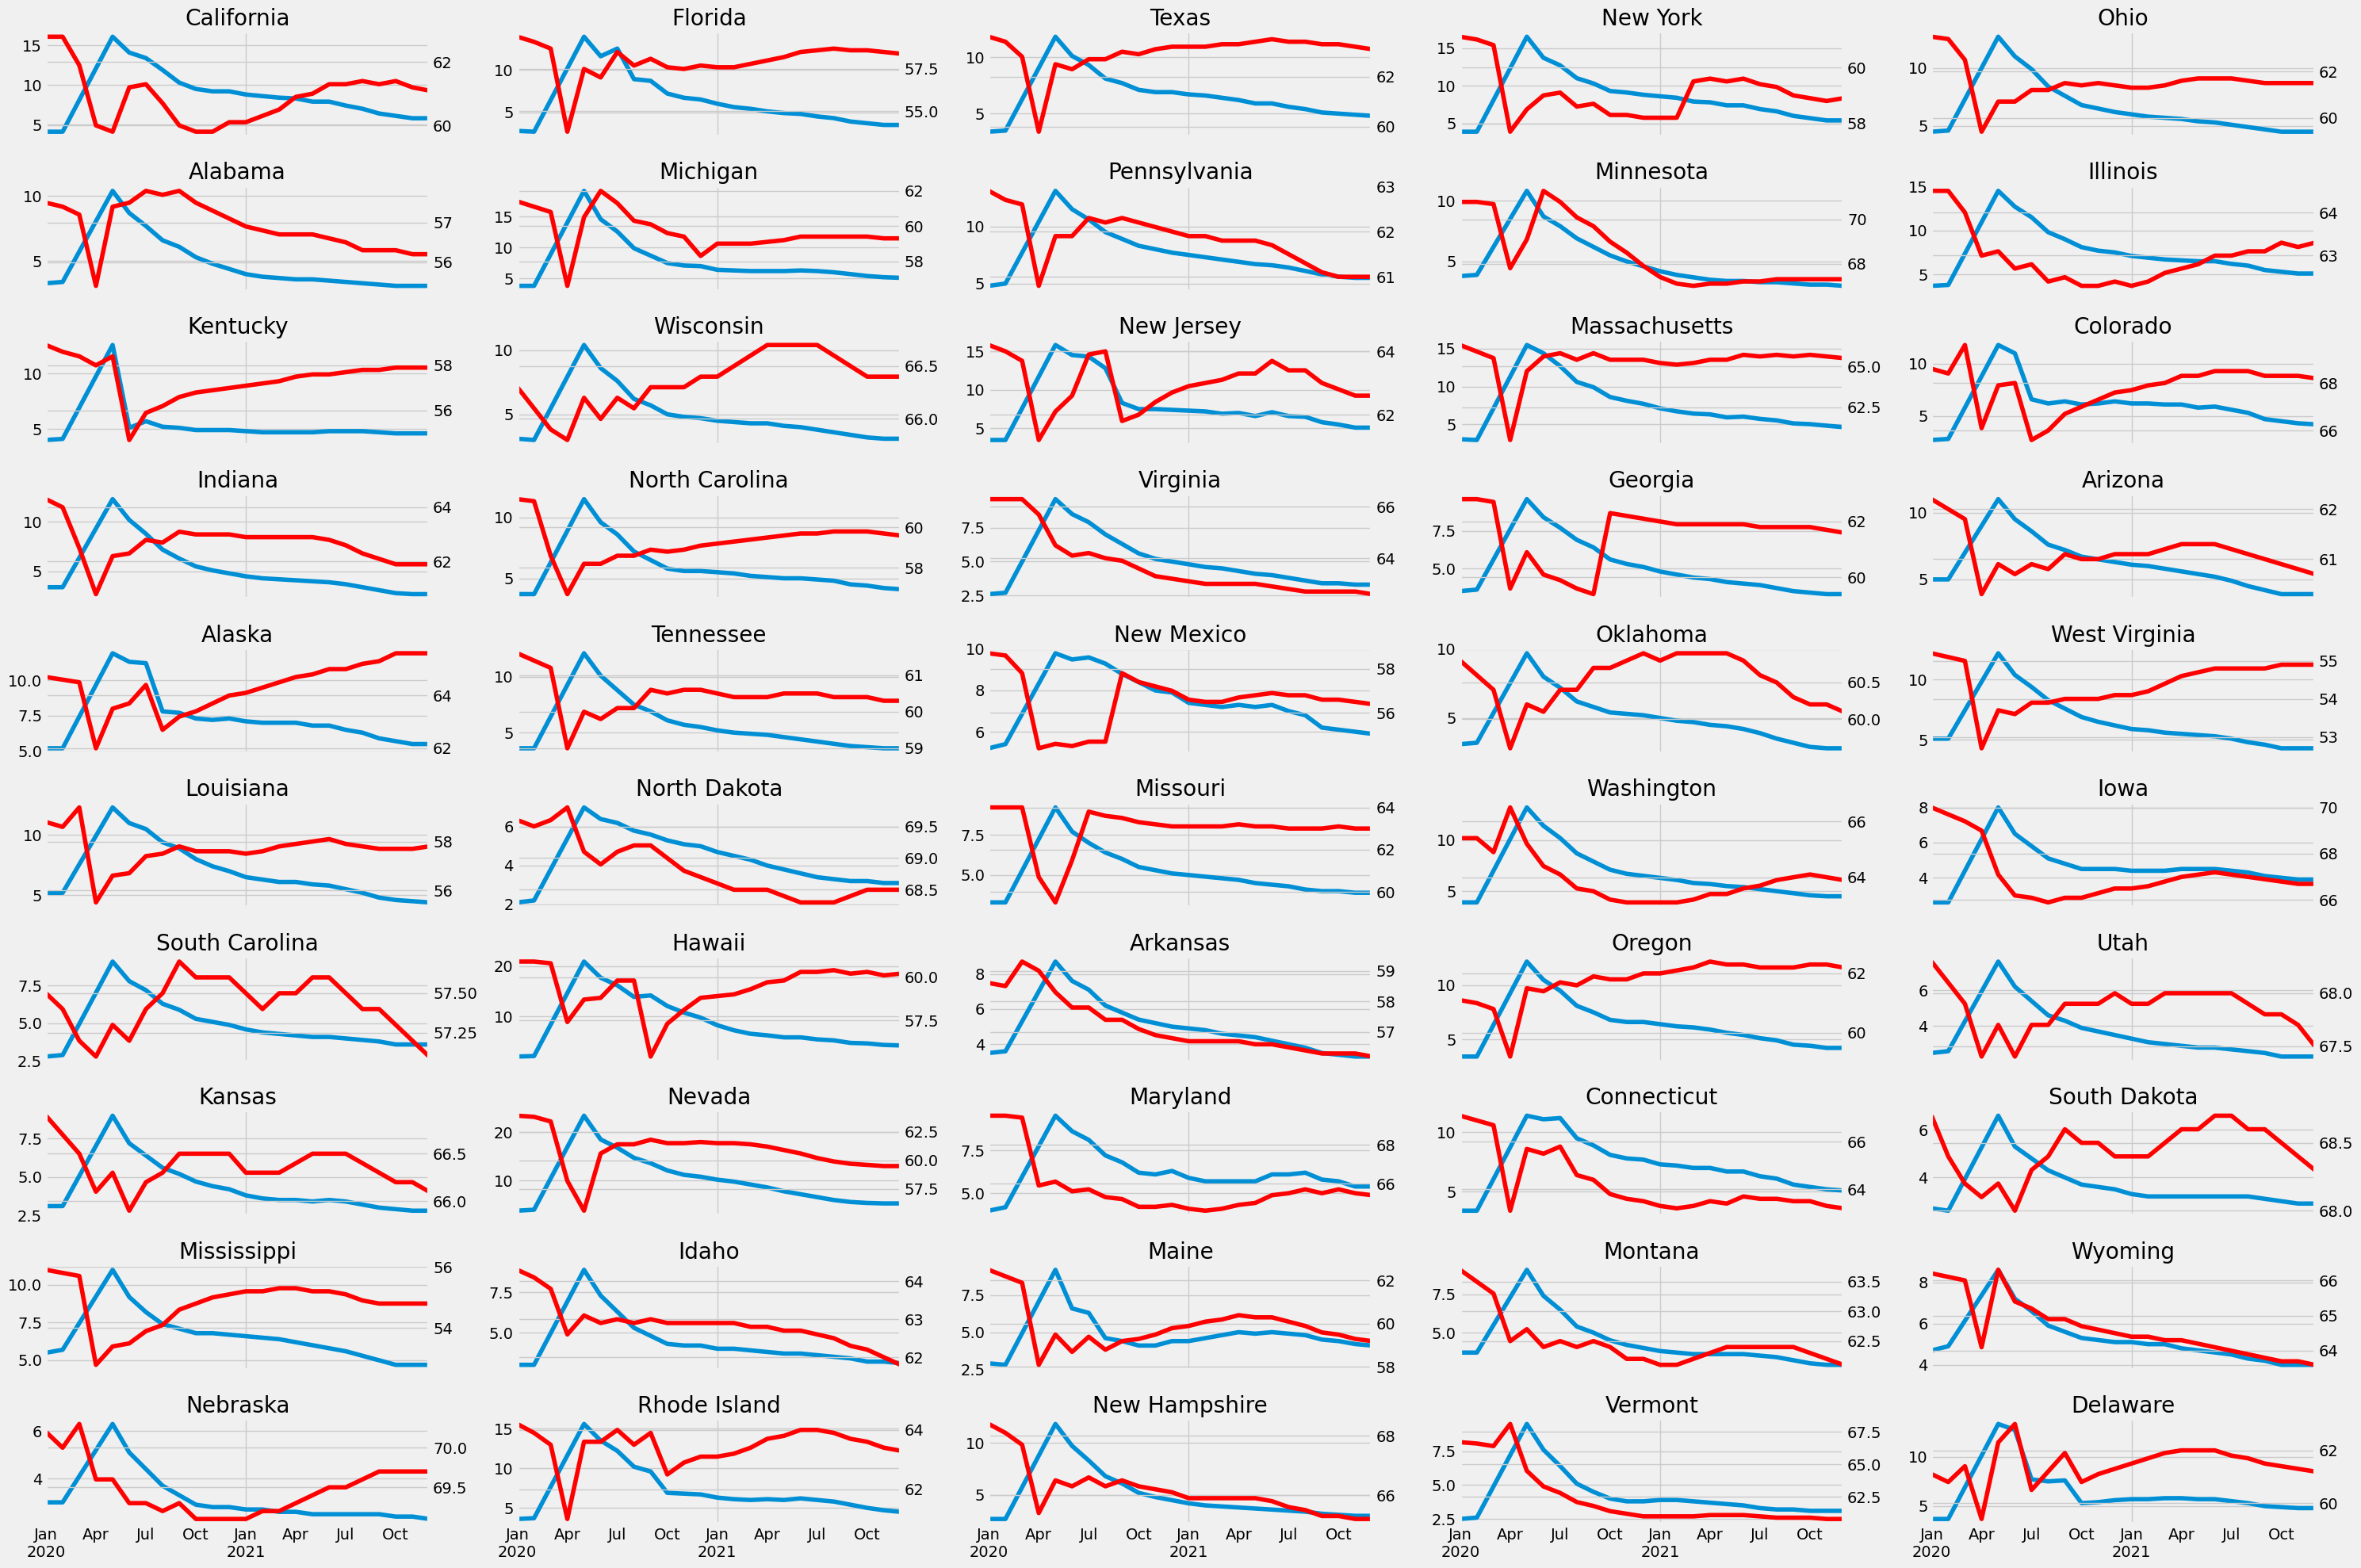

In [18]:
fig, axs = plt.subplots(10, 5, figsize = (30, 20), sharex = True)
axs = axs.flatten()

index = 0
for state in unemp_states.columns: 
    if state == "District of Columbia" or state == "Puerto Rico" :
        continue
    ax2 = axs[index].twinx()
    part_state.query('index >= 2020 and index < 2022')[state].plot(ax = ax2, label = "Participation", color = "red")
    unemp_states.query('index >= 2020 and index < 2022')[state].plot(ax = axs[index], label = "Unemployment")
    axs[index].set_title(state)
    index += 1
plt.tight_layout()

# Analysis of Inflation and Fed Funds Rate during COVID

## Looking at percentage change of federal funds rate

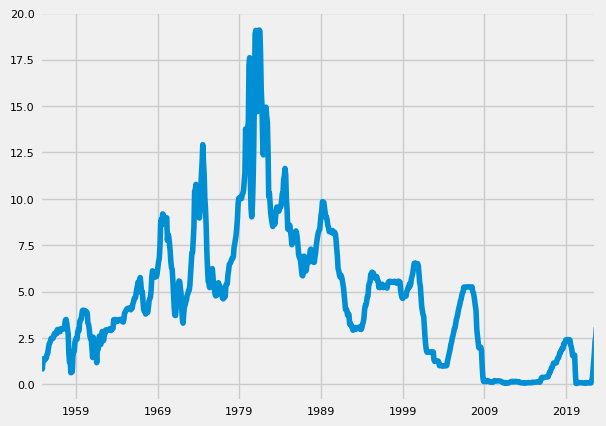

In [64]:
fred.search('fed funds rate', filter = ('frequency', 'Monthly'))
fed_fund = fred.get_series(series_id = "FEDFUNDS").plot()

In [60]:
inflate_df = fred.search('inflation rate', filter = ('frequency', 'Monthly'))
inflate_df = inflate_df.query("seasonal_adjustment == 'Seasonally Adjusted'")
inflate_df = inflate_df.loc[inflate_df['title'].str.contains("Consumer Price Index")]
inflate_df = inflate_df.drop_duplicates()

In [21]:
total_results = []

for myid in inflate_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name = myid)
    total_results.append(results)
    time.sleep(0.1)
inflate_results = pd.concat(total_results, axis = 1)

In [54]:
cols_to_drop = []
for i in inflate_results.columns:
    if len(i) > 7:
        cols_to_drop.append(i)
inflate_results = inflate_results.drop(columns = cols_to_drop, axis = 1)

## Looking at the nominal CPI price increase due to inflation 

<AxesSubplot: xlabel='Year', ylabel='Nominal CPI Prices'>

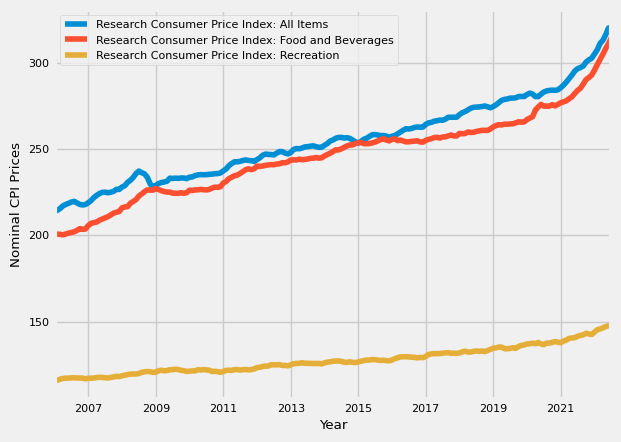

In [56]:
inflate_cpi = inflate_results.dropna()
id_to_cpi = inflate_df['title'].to_dict()
inflate_cpi.columns = [id_to_cpi[c]for c in inflate_results.columns]
inflate_cpi.plot(xlabel = "Year", ylabel = "Nominal CPI Prices")

AttributeError: 'Series' object has no attribute 'set_title'

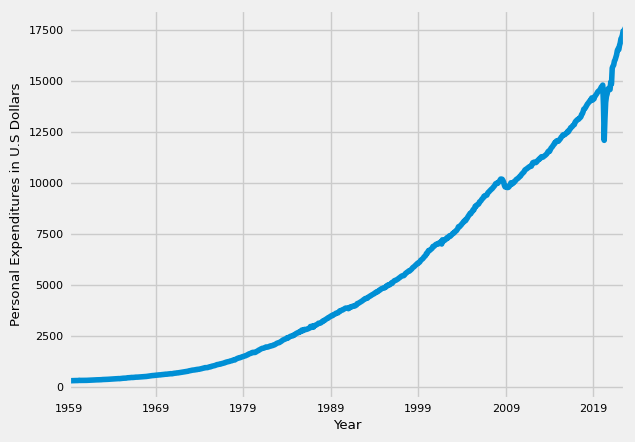

In [72]:
fred.search('consumer expenditure')
expenditure_spend = fred.get_series(series_id = "PCE")
expenditure_spend.plot(xlabel = "Year", ylabel = "Personal Expenditures in U.S Dollars")
plt.plot("Per capita Consumer Expendit")
